# preprocessing

## 1.0 Create vectorizers

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from utils.text_preprocess import LemmaTokenizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
bow_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Plot the most common words

In [2]:
import pandas as pd
df = pd.read_csv('data/amazon_reviews.txt', sep='\t')

C:\Users\Utente\PycharmProjects\amazon_fake_reviews_detection\utils\text_preprocess.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


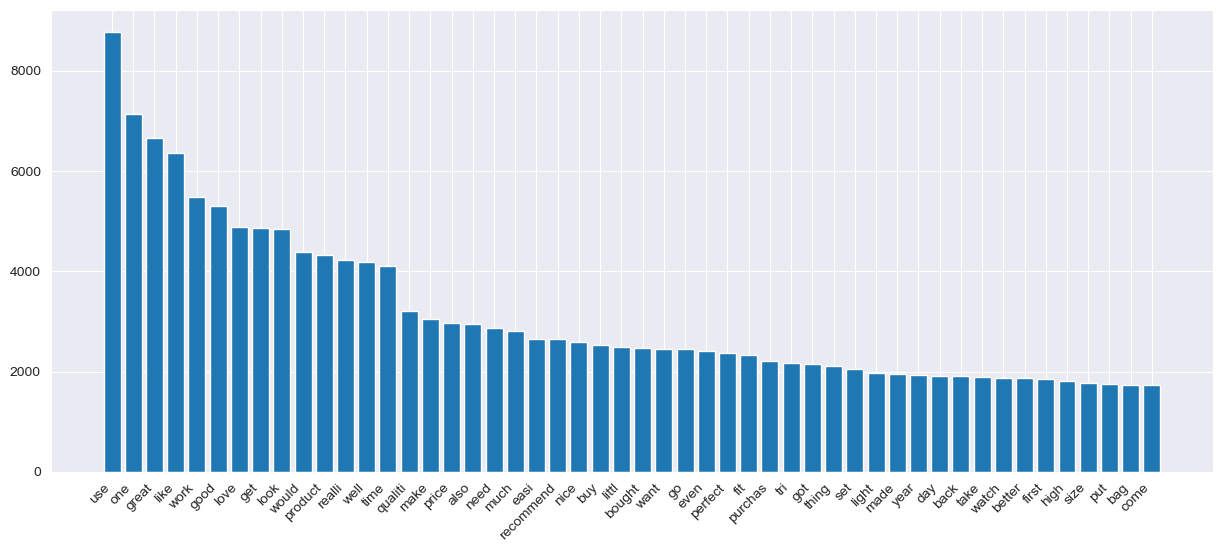

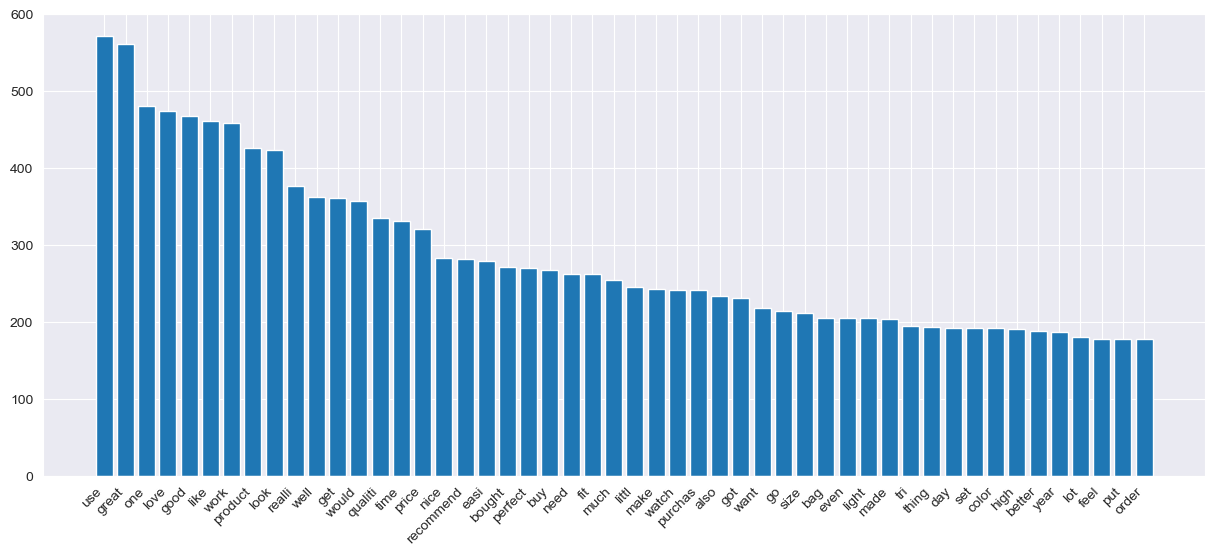

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_most_common_words(vectorizer, n=50):
    X = vectorizer.fit_transform(df['REVIEW_TEXT'])
    words = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(words, counts)))
    most_common = freq_distribution.most_common(n)
    words, counts = zip(*most_common)
    plt.figure(figsize=(15, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_most_common_words(bow_vectorizer)
plot_most_common_words(tfidf_vectorizer)

## 2.0 Word2Vec

In [12]:
from nltk import sent_tokenize
import time
import json
import glob
import os

# Read each JSONL file and append to the list
def create_sentences():
    for file in glob.glob('data/word2vec/*.jsonl'):

        print("Processing file: " + file)
        sentences = set()
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    data = json.loads(line)
                    if 'timestamp' in data and 'text' in data:
                        timestamp = pd.to_datetime(data['timestamp'], unit='ms')
                        if timestamp < pd.Timestamp('2019-01-01'):
                            sentences.update(set(sent_tokenize(data['text'])))
                except json.JSONDecodeError:
                    print(f"Skipping bad line in file {file}")
    
        with open('data/word2vec_processed/sentences.txt', 'a', encoding='utf-8') as f:
            for sentence in sentences:
                if len(sentence) > 2:
                    f.write(sentence + '\n')

if not os.path.exists('data/word2vec_processed/sentences.txt'):
    create_sentences()

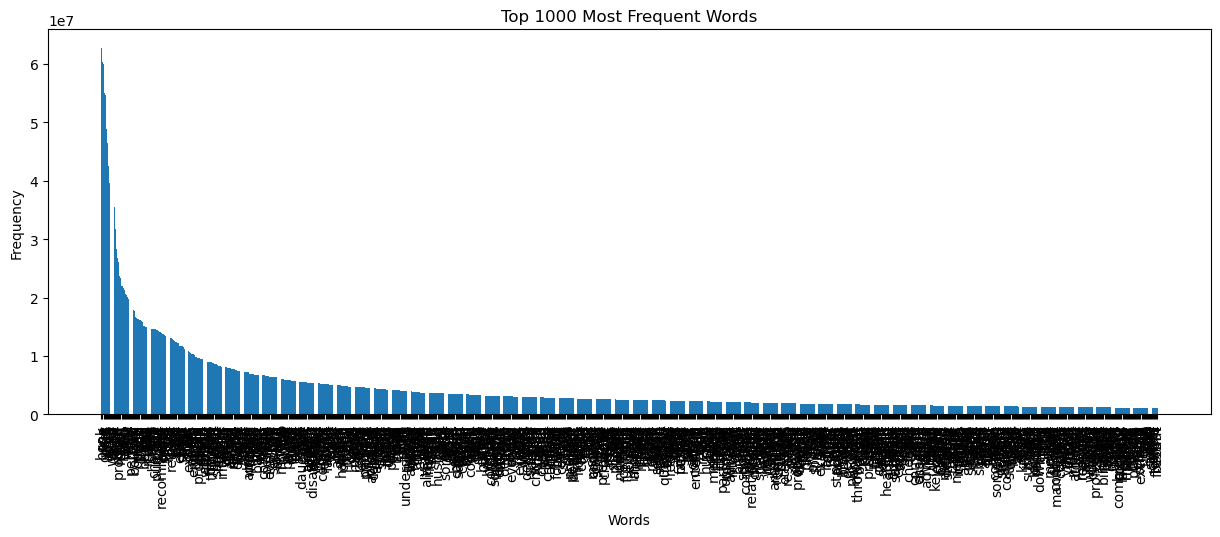

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
import heapq
# Step 1: Read the file and tokenize the words
def count_words_in_chunks(file_path):
    word_counter = Counter()
    
    with open(file_path, 'r') as file:
        for line in file:
            words = line.split()
            word_counter.update(words)  # Update the counter with words in the current line
    
    return word_counter

# Step 3: Plot the top N most frequent words
def plot_word_frequency(word_counter, top_n=1000):
    most_common = heapq.nlargest(top_n, word_counter.items(), key=lambda x: x[1])
    words, frequencies = zip(*most_common)
    
    plt.figure(figsize=(15, 5))
    plt.bar(words, frequencies)
    plt.xticks(rotation=90)
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.show()

# Main Function
file_path = 'data/word2vec_processed/sentences_tokenized.txt'  # Change to your file's path
word_counter = count_words_in_chunks(file_path)
plot_word_frequency(word_counter, top_n=1000)

Train Word2Vec model

In [ ]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from utils.text_preprocess import LemmaTokenizer
from utils.word2vec_callback import Word2VecProgress
import time

# Skip-gram model (sg = 1)
size = 100
window = 5
min_count = 500000
print(f"number of cores: {cpu_count()}")
workers = cpu_count()
sg = 1
# ========= Train the Word2Vec model =========
word2vec_model_file =  'models/word2vec_' + str(size) + '.model'
print("Training Word2Vec Model")
start_time = time.time()

with open('data/word2vec_processed/sentences.txt', 'r', encoding='utf-8') as f1:
    with open('data/word2vec_processed/sentences_tokenized.txt', 'a', encoding='utf-8') as f2:
        for line in f1:
            tokens = LemmaTokenizer()(line)
            if len(tokens) > 0:
                f2.write(' '.join(tokens) + '\n')
            
# Train the Word2Vec Model
w2v_model = Word2Vec(corpus_file='data/word2vec_processed/sentences_tokenized.txt', 
                     min_count = min_count,
                     vector_size = size,
                     workers = workers, 
                     window = window, 
                     sg = sg,
                     callbacks=[Word2VecProgress()])
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

number of cores: 20
Training Word2Vec Model


Plot the word2vec model

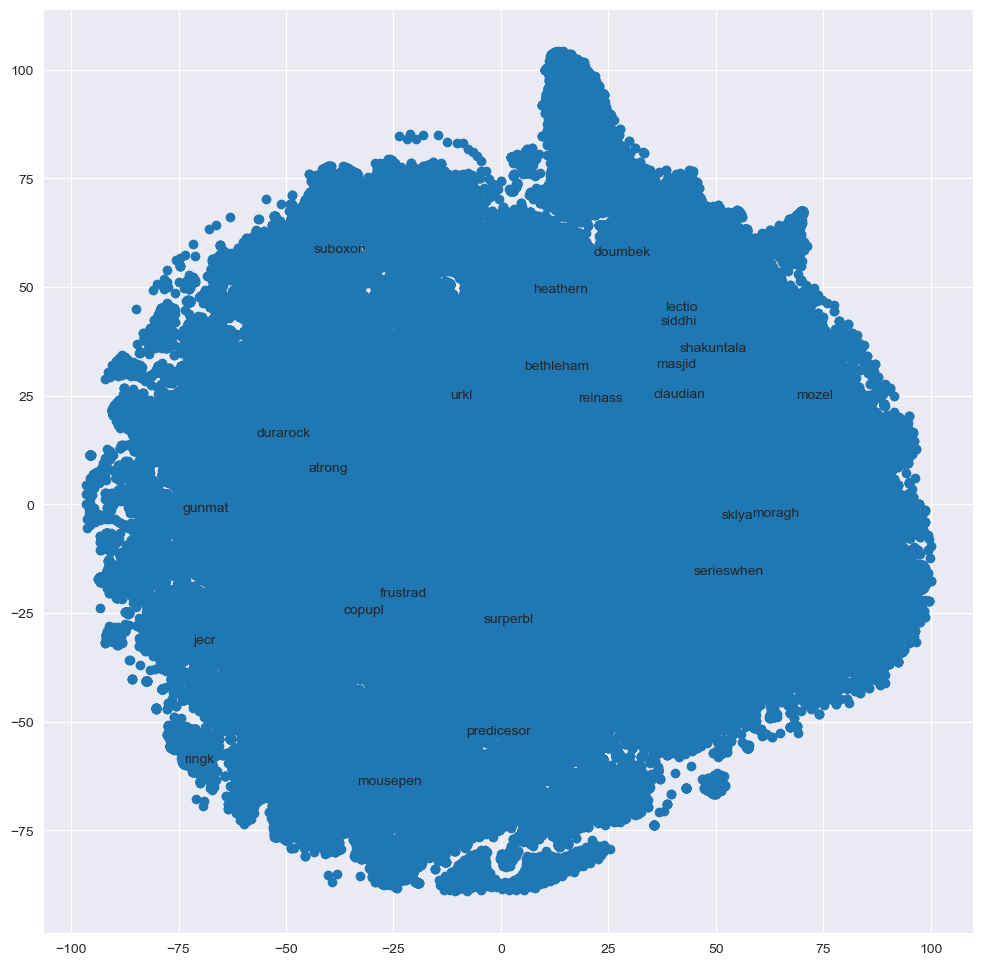

In [4]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np    
from gensim.models import Word2Vec

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

word2vec_model_file =  'models/word2vec_200.model'
model = Word2Vec.load(word2vec_model_file)
x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


import matplotlib.pyplot as plt
import random

random.seed(0)

plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)

#
# Label randomly subsampled 25 data points
#
indices = list(range(len(labels)))
selected_indices = random.sample(indices, 25)
for i in selected_indices:
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))
plt.show()